In [1]:
import glob
import os
from datetime import datetime, timedelta

import gas_cooling as gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants as const
from experiment import influx
from materials import silicon, teflon

plt.style.use("seaborn-poster")

pd.set_option("display.max_rows", 100)

start = "2022-10-11T11:40:00Z"
stop = "2022-10-14T10:17:00Z"

# data = influx.get_data()
data = influx.get_data(
    field="T-testmass", start=start, stop=stop, measurement="second run"
)
# ["T-testmass"]

ModuleNotFoundError: No module named 'gas_cooling'

In [2]:
temp_tm = data.set_index("_time")["T-testmass"]

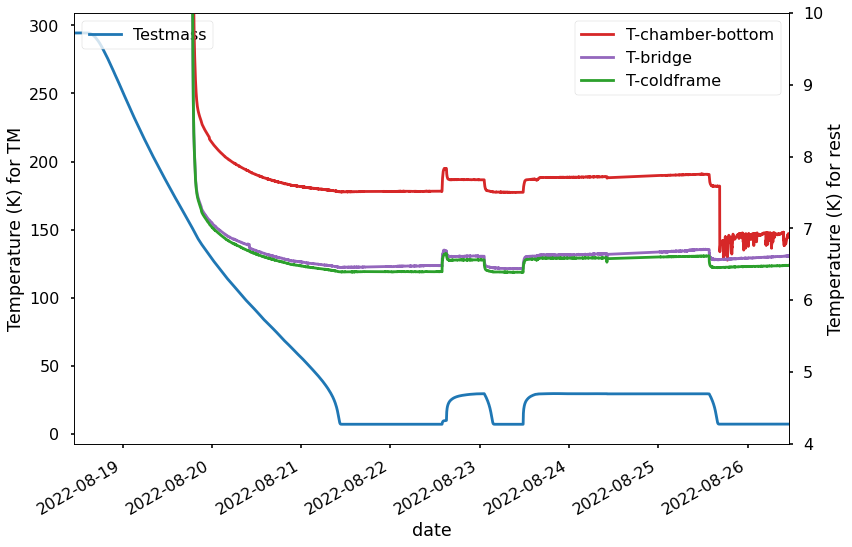

In [37]:
df = temp_tm
# df = df.drop("P-Cryo", axis=1)


now = datetime.now()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylim(bottom=4, top=10)
ax1.set_xlim([now - timedelta(days=28), now - timedelta(days=20)])

df["T-testmass"].plot(ax=ax1, label="Testmass")
df["T-chamber-bottom"].plot(ax=ax2, color="C3")
df["T-bridge"].plot(ax=ax2, color="C4")
df["T-coldframe"].plot(ax=ax2, color="C2")
# df["P-Cryo"].plot(ax=ax2, color="C5")

# df = df.drop("P-Cryo", axis=1)
ax1.set_ylabel("Temperature (K) for TM")
ax2.set_ylabel("Temperature (K) for rest")

ax1.legend(loc="upper left")
ax2.legend()

Text(0, 0.5, 'Temperature (K) for rest')

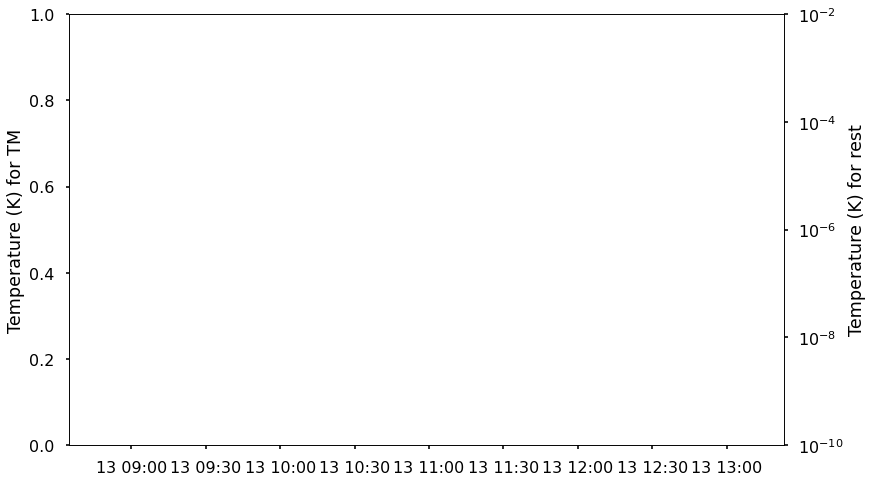

In [34]:
df = log("Data/Cryo_logger/2022/08/").sort_index()
# df = df.drop("P-Cryo", axis=1)


now = datetime.now()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylim(bottom=1e-10, top=1e-2)
ax1.set_xlim([now - timedelta(days=2.1), now - timedelta(days=1.9)])

# df["T-testmass"].plot(ax=ax1, label="Testmass")
# df["T-chamber-bottom"].plot(ax=ax2, color="C3")
# df["T-bridge"].plot(ax=ax2, color="C4")
# df["T-coldframe"].plot(ax=ax2, color="C2")
df["P-Cryo"].plot(ax=ax2, color="C5", logy=True)

# df = df.drop("P-Cryo", axis=1)
ax1.set_ylabel("Temperature (K) for TM")
ax2.set_ylabel("Temperature (K) for rest")

In [ ]:
# Calculation $P_	ext{cool}$
we take the T-testmass data during cool down and 

In [4]:
testmass = df
testmass = testmass[
    testmass.index
    > datetime.strptime("2022-08-18 17:51:59.248830+02:00", "%Y-%m-%d %H:%M:%S.%f%z")
]
testmass = testmass[
    testmass.index
    < datetime.strptime("2022-08-21 13:51:59.248830+02:00", "%Y-%m-%d %H:%M:%S.%f%z")
]


starting_timestamp = testmass.index[0]
testmass["time (s)"] = (testmass.index - starting_timestamp).total_seconds()
testmass = testmass.set_index("time (s)")
# display(testmass)
# testmass["T-testmass"].plot()
display(testmass)

,T-bridge,T-chamber-bottom,T-coldframe,T-testmass
time (s),,,,
0.000000,260.1530,270.2510,265.8210,286.5830
60.001179,259.9940,270.0880,265.6560,286.5190
120.018449,259.8500,269.9180,265.4880,286.4560
180.034983,259.6850,269.7600,265.3240,286.3700
240.048538,259.5360,269.5800,265.1500,286.2860
...,...,...,...,...
244457.204263,6.4600,7.5099,6.3946,7.2776
244517.216185,6.4606,7.5103,6.3951,7.2775
244577.227414,6.4596,7.5108,6.3945,7.2776


# Heat flux out of the test mass

## Measurement during cool down (no laser is heating)
The test mass has a weight of 
m = 118 g

The heat flux is given by
$$P_\text{total flux}  = \frac{\partial Q}{\partial t} \approx c(T) m \frac{\partial T}{\partial t}$$

with the temperature dependent specific heat capacity $c(T)$

In [5]:
si = silicon.Silicon()
testmass["total heat flux (W)"] = (
    0.118
    * si.specific_heat(testmass["T-testmass"])
    * (testmass["T-testmass"].diff() / testmass.index.to_series().diff()).fillna(0)
)
testmass["total heat flux (W) average"] = (
    testmass["total heat flux (W)"].rolling(window=30).mean()
)
cooling_rate = testmass.set_index("T-testmass")

## Conductive heat flux through the teflon screws

The conductive heat flux is calculated with Fourier's law
$$ \vec{q} = -k \nabla T$$

The temperature gradient is simply the difference between TM holder and TM divided by 2 mm.

We have 7 screws, each with a connecting round surface with radius $d=0.5$mm

Therefore:
$$ P_\text{conduction} = -7 r^2 \pi k(T) \nabla T$$
with the temperature dependent thermal conductivity $k(T)$

In [19]:
radius_screw_tip = 0.3e-3
factor = -7 * (radius_screw_tip) ** 2 * np.pi
cooling_rate["T diff between frame and TM"] = (
    cooling_rate.index - cooling_rate["T-coldframe"]
)
cooling_rate["nabla T"] = cooling_rate["T diff between frame and TM"] / 2e-3
cooling_rate["conductive heat flux (W)"] = (
    factor
    * teflon.heat_conductivity(cooling_rate["T-coldframe"])
    * cooling_rate["nabla T"]
)
display(cooling_rate)

,T-bridge,T-chamber-bottom,T-coldframe,total heat flux (W),total heat flux (W) average,T diff between frame and TM,nabla T,conductive heat flux (W),radiation (W)
T-testmass,,,,,,,,,
286.5830,260.1530,270.2510,265.8210,0.000000e+00,NaN,20.7620,10381.00,-0.005583,-1.934200e-02
286.5190,259.9940,270.0880,265.6560,-8.793995e-02,NaN,20.8630,10431.50,-0.005610,-1.932472e-02
286.4560,259.8500,269.9180,265.4880,-8.653273e-02,NaN,20.9680,10484.00,-0.005638,-1.930773e-02
286.3700,259.6850,269.7600,265.3240,-1.181070e-01,NaN,21.0460,10523.00,-0.005659,-1.928456e-02
286.2860,259.5360,269.5800,265.1500,-1.153483e-01,NaN,21.1360,10568.00,-0.005683,-1.926194e-02
...,...,...,...,...,...,...,...,...,...
7.2776,6.4600,7.5099,6.3946,6.254807e-08,-4.169331e-09,0.8830,441.50,-0.000061,-8.043634e-09
7.2775,6.4606,7.5103,6.3951,-2.084868e-08,-4.169091e-09,0.8824,441.20,-0.000061,-8.043192e-09
7.2776,6.4596,7.5108,6.3945,2.084978e-08,-5.559928e-09,0.8831,441.55,-0.000061,-8.043634e-09


In [20]:
def gray_body_thermal_radiation(emissivity, temperature, surface_area):
    return emissivity * const.Stefan_Boltzmann * surface_area * temperature**4

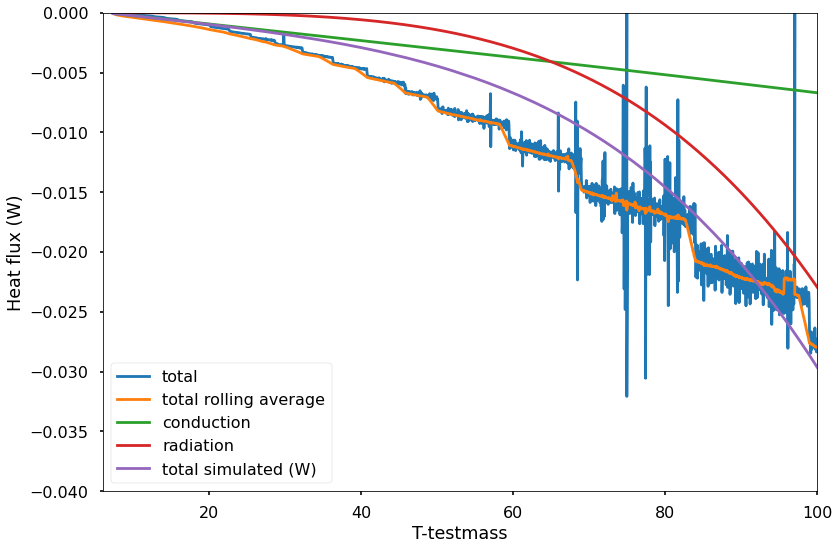

In [36]:
((cooling_rate["total heat flux (W)"]).plot(xlim=[6, 100], label="total"))
(
    (cooling_rate["total heat flux (W) average"]).plot(
        xlim=[6, 100], label="total rolling average"
    )
)
(
    (cooling_rate["conductive heat flux (W)"]).plot(
        xlim=[6, 100], ylim=[-0.04, 0], label="conduction"
    )
)
surface_area = 0.0998 * (2.54 / 200) ** 2 * np.pi
cooling_rate["radiation (W)"] = (
    -gray_body_thermal_radiation(1, cooling_rate.index, surface_area)
) * 80
(cooling_rate["radiation (W)"]).plot(label="radiation")
cooling_rate["total simulated (W)"] = (
    cooling_rate["radiation (W)"] + cooling_rate["conductive heat flux (W)"]
)
cooling_rate["total simulated (W)"].plot()
plt.ylabel("Heat flux (W)")

plt.legend()

# Cooling by radiation (fitting the emissivity)

*Gray body radiation* is given by
$$
P_\text{radiation} = \epsilon \sigma A T^4$$
with the emissivity $\epsilon$, Stefan Boltzmann Constant $\sigma$, surface area $A$ and temperature $T$

In [106]:
# cooling_rate["radiation (W)"] = cooling_rate["total heat flux (W) average"] - cooling_rate["conductive heat flux (W)"]
# cooling_rate["emissivity"] = cooling_rate["radiation (W)"] / (surface_area * const.Stefan_Boltzmann * cooling_rate.index**(1/4))

<AxesSubplot:xlabel='T-testmass'>

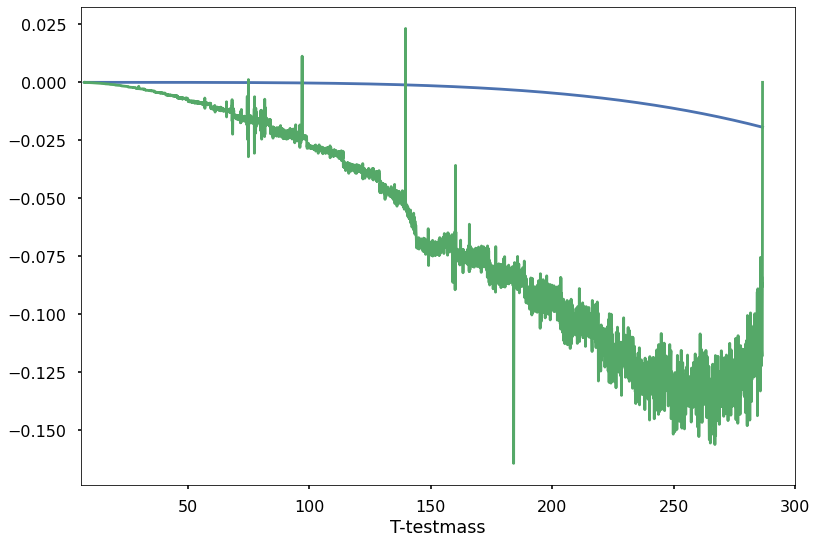

In [108]:
cooling_rate["radiation (W)"].plot()
((cooling_rate["total heat flux (W)"]).plot(xlim=[6, 300], label="total"))